In [1]:
%matplotlib inline 

import numpy as np
import scipy
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
from mpl_toolkits.mplot3d import Axes3D #3D plotting
import datetime as dt # module for manipulating dates and times

import requests 
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import binom
from scipy.optimize import minimize_scalar
from __future__ import division
import re
from StringIO import StringIO
from zipfile import ZipFile 
from pandas import read_csv
from urllib import urlopen
import urllib2
import json

import sklearn
import sklearn.preprocessing
import sklearn.datasets

# Gaussian Shocks

### LMSR ACCORDING TO Brahma et al.

In [2]:
# LMSR Implementation Das Interpretation
# according to http://www.cse.wustl.edu/~mithunchakraborty/papers/AAAI15poster_final.pdf
def runlmsr_gaussian(iterations, trialnumber, MMb, traderAlphaExponential, shock_prob, shock_sd):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)
    rmse = np.zeros(trialnumber)
    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        
        difference = np.zeros(iterations)

        for time in np.arange(1,iterations,1):
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            if traderValue > MMprice_1[time - 1]:
                quantityEquivalentprice = MMb*(np.log((traderValue*(np.exp(currentquantity_2/MMb))/100) / \
                                                      (1-traderValue/100)))-currentquantity_1
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_1 = min(quantityTrader, quantityEquivalentprice)
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityEquivalentprice = MMb*(np.log(((100-traderValue)*(np.exp(currentquantity_1/MMb))/100)/ \
                                                      (1-(100-traderValue)/100)))-currentquantity_2
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_2 = min(quantityTrader, quantityEquivalentprice)
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(np.exp(newquantity_1/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            MMprice_2[time] = 100*(np.exp(newquantity_2/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            difference[time] = (MMprice_1[time] - trueValue[time]) ** 2
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
        rmse[i] = np.sqrt(np.sum(difference)/iterations)
    return trial_1, trial_2, trueValue, MMprice_1, rmse

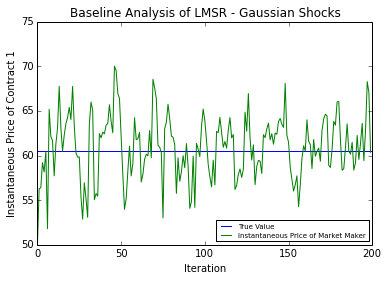

433.578356243
4221.9755021
-8398.35125181


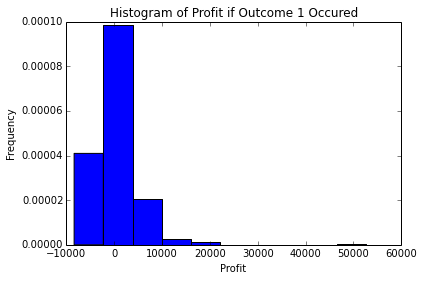

722.22354372
4081.59668822
-8571.36799586


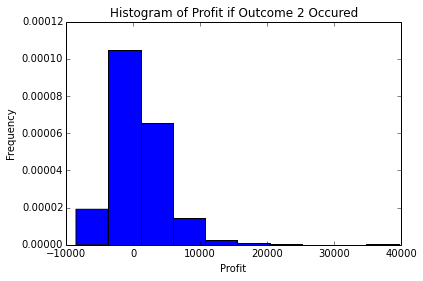

3.67361413447


In [3]:
# Baseline Revenue Results 
trial_1, trial_2, trueValue, MMprice_1, rmse = runlmsr_gaussian(200, 1000, 125, 20, 1/100, 5)

# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.xlabel('Iteration')
plt.ylabel('Instantaneous Price of Contract 1')
plt.title('Baseline Analysis of LMSR - Gaussian Shocks')
plt.legend(('True Value', 'Instantaneous Price of Market Maker'),4, fontsize='x-small')
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))

plt.hist(trial_1, normed=1)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Histogram of Profit if Outcome 1 Occured')
plt.show()

#outcome 2 occurs
print(np.average(trial_2))
print(np.std(trial_2))
print(np.min(trial_2))
plt.hist(trial_2, normed=1)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Histogram of Profit if Outcome 2 Occured')
plt.show()

print(np.mean(rmse))

In [13]:
beta = [10, 50, 125, 250,500]

for betaspecific in beta:
    # Baseline Revenue Results 
    trial_1, trial_2, trueValue, MMprice_1, rmse = runlmsr_gaussian(200, 1000, betaspecific, 20, 1/100, 5)
    print(np.average(trial_1))
    print(np.std(trial_1))
    print(np.min(trial_1))
    print(np.average(trial_2))
    print(np.std(trial_2))
    print(np.min(trial_2))
    print(np.mean(rmse))

39.9321810982
343.835429723
-664.137081287
60.268285461
345.713132392
-683.030741065
4.80763233033
279.383188135
1659.79108309
-3027.01979635
193.561460764
1599.07905862
-3292.67363426
4.26685057192
763.444891319
5222.34912553
-8438.6393992
502.490738453
4121.74231088
-8661.61571458
3.68114091148
821.892701168
9064.69187234
-15726.4562191
1701.88308194
8565.44060489
-17268.4793151
3.27446283375
2230.40979667
15996.5841988
-32469.706046
2565.14902682
17059.521645
-30817.0763182
3.10250151088


### LMSR TEXTBOOK

In [4]:
# LMSR Implementation Textbook Interpretation
def runlmsr_gaussiantextbook(iterations, trialnumber, MMb, traderAlphaExponential, shock_prob, shockSD):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)

    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMquantity_1[0] = 0
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMquantity_2[0] = 0
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        MMpayment[0] = 0

        for time in np.arange(1,iterations,1):
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            if traderValue > MMprice_1[time - 1]:
                quantityTrader_1 = MMb*(np.log((traderValue*(np.exp(currentquantity_2/MMb))/100) / \
                                                      (1-traderValue/100)))-currentquantity_1
                # error checking
                if quantityTrader_1 < 0 and traderValue<90.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2, quantityTrader_1
                    raise NameError('Problem with Quantity Calculation')
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityTrader_2 = MMb*(np.log(((100-traderValue)*(np.exp(currentquantity_1/MMb))/100)/ \
                                                      (1-(100-traderValue)/100)))-currentquantity_2
                # error checking
                if quantityTrader_2 < 0 and traderValue<90.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2, quantityTrader_2
                    raise NameError('Problem with Quantity Calculation')
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(np.exp(newquantity_1/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            MMprice_2[time] = 100*(np.exp(newquantity_2/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
    return trial_1, trial_2, trueValue, MMprice_1


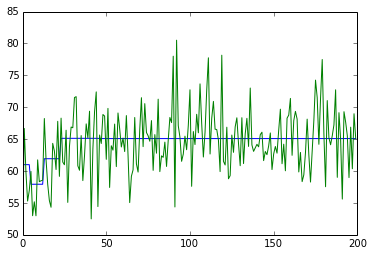

797.336224597
5359.30468355
-8663.0896945


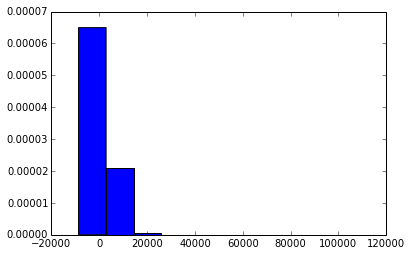

705.597238106
6287.47781319
-8663.0896945


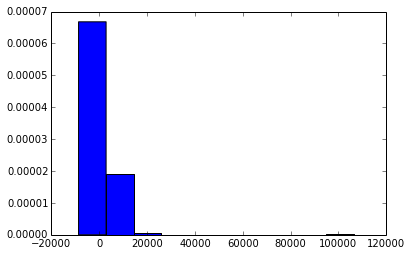

In [5]:
# Baseline Revenue Results 
trial_1, trial_2, trueValue, MMprice_1 = runlmsr_gaussiantextbook(200, 1000, 125, 20, 1/100, 5)
# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))
plt.hist(trial_1, normed=1)
plt.show()

#outcome 2 occurs
print(np.average(trial_2))
print(np.std(trial_2))
print(np.min(trial_2))
plt.hist(trial_2, normed=1)
plt.show()


### Liquidity Sensitive LMSR Implementation Das Interpretation


In [6]:
#Liquidity Sensitive LMSR Implementation Das Interpretation

def runlslmsr_gaussian(iterations, trialnumber, traderAlphaExponential, shock_prob, shock_sd, alpha, initialsubsidy):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)

    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMquantity_1[0] = initialsubsidy
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMquantity_2[0] = initialsubsidy
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        MMpayment[0] = 0

        for time in np.arange(1,iterations,1):
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            MMb = alpha*(currentquantity_1 + currentquantity_2)
            
            if traderValue > MMprice_1[time - 1]:
                quantityTrader_1 = quantityTrader
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityTrader_2 = quantityTrader
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
                
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_2*(np.exp(newquantity_1/MMb)-np.exp(newquantity_2/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            MMprice_2[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_1*(np.exp(newquantity_2/MMb)-np.exp(newquantity_1/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
    return trial_1, trial_2, trueValue, MMprice_1

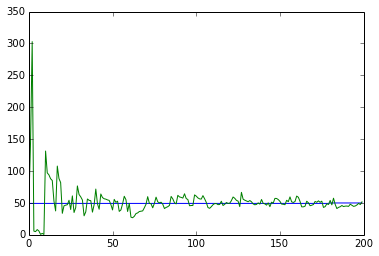

3168.41355455
7258.9543322
-8248.02666289


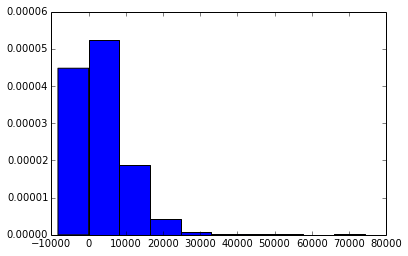

663.8057358
6022.79145136
-9088.51148588


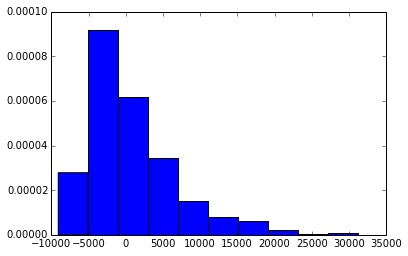

In [7]:
# Baseline Revenue Results 
trial_1, trial_2, trueValue, MMprice_1 = runlslmsr_gaussian(200, 1000, 20, 1/100, 5, 0.05, 10)
# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))
plt.hist(trial_1, normed=1)
plt.show()

#outcome 2 occurs
print(np.average(trial_2))
print(np.std(trial_2))
print(np.min(trial_2))
plt.hist(trial_2, normed=1)
plt.show()


### Liquidity sensitive - trying an optimzer to solve for myopic trader

In [8]:
#Liquidity Sensitive LMSR Implementation Das Interpretation

def runlslmsr_gaussianmyopic(iterations, trialnumber, traderAlphaExponential, shock_prob, shock_sd, alpha, initialsubsidy):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)

    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMquantity_1[0] = initialsubsidy
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMquantity_2[0] = initialsubsidy
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        MMpayment[0] = 0

        for time in np.arange(1,iterations,1):
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            MMb = alpha*(currentquantity_1 + currentquantity_2)
            
            if traderValue > MMprice_1[time - 1]:
                f = lambda q: alpha*np.log(np.exp(q/MMb) + \
                                           np.exp(currentquantity_2/MMb)) + (currentquantity_2*(np.exp(q/MMb) - \
                                           np.exp(currentquantity_2/MMb))) / ((q+currentquantity_2)*(np.exp(q/MMb) + \
                                           np.exp(currentquantity_2/MMb)))
                res = minimize_scalar(f, method='brent')
                if res.x > 0 and res.success == 1:
                    quantityTrader_1 = min(quantityTrader, res.x)
                else:
                    quantityTrader_1 = quantityTrader
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                f = lambda q: alpha*np.log(np.exp(q/MMb) + \
                                           np.exp(currentquantity_1/MMb)) + (currentquantity_1*(np.exp(q/MMb) - \
                                           np.exp(currentquantity_1/MMb))) / ((q+currentquantity_1)*(np.exp(q/MMb) + \
                                           np.exp(currentquantity_1/MMb)))
                res = minimize_scalar(f, method='brent')
                if res.x > 0 and res.success == 1:
                    quantityTrader_2 = min(quantityTrader, res.x)
                else:
                    quantityTrader_2 = quantityTrader
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
                
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_2*(np.exp(newquantity_1/MMb)-np.exp(newquantity_2/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            MMprice_2[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_1*(np.exp(newquantity_2/MMb)-np.exp(newquantity_1/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
    return trial_1, trial_2, trueValue, MMprice_1

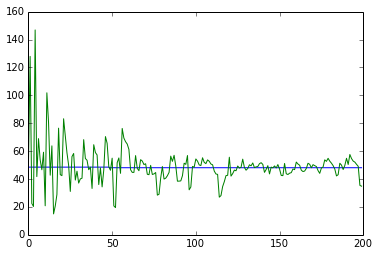

3034.48554339
7055.34430207
-8759.18844587


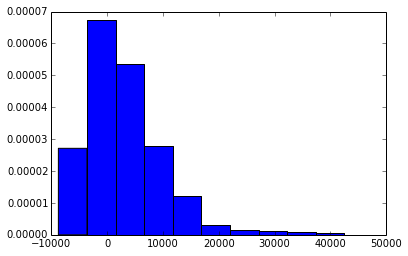

802.932252205
6719.82646925
-9297.03587548


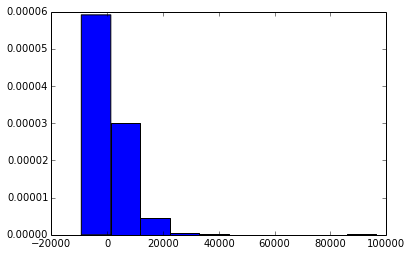

In [9]:
# Baseline Revenue Results 
trial_1, trial_2, trueValue, MMprice_1 = runlslmsr_gaussianmyopic(200, 1000, 20, 1/100, 5, 0.05, 10)
# plot sample simulation
xs = np.arange(0,200,1)
plt.plot(xs, trueValue, xs, MMprice_1)
plt.show() 

# outcome 1 occurs
print(np.average(trial_1))
print(np.std(trial_1))
print(np.min(trial_1))
plt.hist(trial_1, normed=1)
plt.show()

#outcome 2 occurs
print(np.average(trial_2))
print(np.std(trial_2))
print(np.min(trial_2))
plt.hist(trial_2, normed=1)
plt.show()


## COMBINATION (RUNNING LMSR AT SAME TIME AS LS LMSR)

In [11]:
# LMSR Implementation Das Interpretation
# according to http://www.cse.wustl.edu/~mithunchakraborty/papers/AAAI15poster_final.pdf
def bothlmsr_gaussian(iterations, trialnumber, typMMb, traderAlphaExponential, shock_prob, shock_sd, alpha):
    typtrial_1 = np.zeros(trialnumber)
    typtrial_2 = np.zeros(trialnumber)
    typrmse = np.zeros(trialnumber)
    lstrial_1 = np.zeros(trialnumber)
    lstrial_2 = np.zeros(trialnumber)
    lsrmse = np.zeros(trialnumber)
    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        typeMMquantity_1 = np.zeros(iterations)
        typMMprice_1 = np.zeros(iterations)
        typMMprice_1[0] = 50
        lsMMquantity_1 = np.zeros(iterations)
        lsMMprice_1 = np.zeros(iterations)
        lsMMprice_1[0] = 50
        
        #outcome 2
        typMMquantity_2 = np.zeros(iterations)
        typMMprice_2 = np.zeros(iterations)
        typMMprice_2[0] = 50
        lsMMquantity_2 = np.zeros(iterations)
        lsMMprice_2 = np.zeros(iterations)
        lsMMprice_2[0] = 50
        
        #revenue
        typMMpayment = np.zeros(iterations)
        lsMMpayment = np.zeros(iterations)
        
        typdifference = np.zeros(iterations)
        lsdifference = np.zeros(iterations)

        for time in np.arange(1,iterations,1):
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            
            # STANDARD LMSR 
            currentquantity_1 = np.sum(typMMquantity_1)
            currentquantity_2 = np.sum(typMMquantity_2)
            MMb = typMMb
            
            if traderValue > typMMprice_1[time - 1]:
                quantityEquivalentprice = MMb*(np.log((traderValue*(np.exp(currentquantity_2/MMb))/100) / \
                                                      (1-traderValue/100)))-currentquantity_1
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, typMMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_1 = min(quantityTrader, quantityEquivalentprice)
                typMMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityEquivalentprice = MMb*(np.log(((100-traderValue)*(np.exp(currentquantity_1/MMb))/100)/ \
                                                      (1-(100-traderValue)/100)))-currentquantity_2
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, typMMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_2 = min(quantityTrader, quantityEquivalentprice)
                typMMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
            typMMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            typMMprice_1[time] = 100*(np.exp(newquantity_1/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            typMMprice_2[time] = 100*(np.exp(newquantity_2/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            typdifference[time] = (typMMprice_1[time] - trueValue[time]) ** 2
            
            # LIQUID SENSITIVE LMSR
            currentquantity_1 = np.sum(lsMMquantity_1)
            currentquantity_2 = np.sum(lsMMquantity_2)
            MMb = alpha*(currentquantity_1 + currentquantity_2)
            if traderValue > lsMMprice_1[time - 1]:
                quantityTrader_1 = quantityTrader
                lsMMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityTrader_2 = quantityTrader
                lsMMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
                
            lsMMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            lsMMprice_1[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_2*(np.exp(newquantity_1/MMb)-np.exp(newquantity_2/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            lsMMprice_2[time] = 100*(alpha*np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)) + \
                                       (newquantity_1*(np.exp(newquantity_2/MMb)-np.exp(newquantity_1/MMb))) / \
                                       ((newquantity_1 + newquantity_2)*(np.exp(newquantity_1/MMb) + np.exp(newquantity_2/MMb))))
            lsdifference[time] = (lsMMprice_1[time] - trueValue[time]) ** 2
        typtrial_1[i] = np.sum(typMMpayment)-100*np.sum(typMMquantity_1)
        typtrial_2[i] = np.sum(typMMpayment)-100*np.sum(typMMquantity_2)
        typrmse[i] = np.sqrt(np.sum(typdifference)/iterations)        
        lstrial_1[i] = np.sum(lsMMpayment)-100*np.sum(lsMMquantity_1)
        lstrial_2[i] = np.sum(lsMMpayment)-100*np.sum(lsMMquantity_2)
        lsrmse[i] = np.sqrt(np.sum(lsdifference)/iterations)
    return trial_1, trial_2, trueValue, MMprice_1, rmse

## Uniform Shock

In [ ]:
# LMSR Implementation Das Interpretation
# according to http://www.cse.wustl.edu/~mithunchakraborty/papers/AAAI15poster_final.pdf
def runlmsr_uniform(iterations, trialnumber, MMb, traderAlphaExponential):
    trial_1 = np.zeros(trialnumber)
    trial_2 = np.zeros(trialnumber)
    rmse = np.zeros(trialnumber)
    for i in np.arange(0,trialnumber,1):
        # Initialize Market Model
        initialValue = np.random.normal(50,12)
        if initialValue < 0:
            initialValue = 0
        if initialValue > 100:
            initialValue = 100

        # shock values
        shock_prob= 1/100
        shockSD = 5
        # true asset value
        trueValue = np.zeros(iterations)
        trueValue[0] = initialValue

        # Initial Trade Values
        traderSD = 5
        traderValueAll = np.zeros(iterations)
        traderValueAll[0] = initialValue

        #initial MM values

        #outcome 1
        MMquantity_1 = np.zeros(iterations)
        MMprice_1 = np.zeros(iterations)
        MMprice_1[0] = 50

        #outcome 2
        MMquantity_2 = np.zeros(iterations)
        MMprice_2 = np.zeros(iterations)
        MMprice_2[0] = 50

        #revenue
        MMpayment = np.zeros(iterations)
        
        difference = np.zeros(iterations)

        for time in np.arange(1,iterations,1):
            if np.random.binomial(1,shock_prob) == 1:
                initialValue = initialValue + np.random.normal(0, shockSD)
            trueValue[time] = initialValue
            traderValue = np.random.normal(initialValue, traderSD)
            traderValueAll[time] = traderValue
            # normalize trader value
            if traderValue <= 0:
                traderValue = 0.01
            if traderValue >= 100:
                traderValue = 99.99
            quantityTrader = np.random.exponential(traderAlphaExponential)
            currentquantity_1 = np.sum(MMquantity_1)
            currentquantity_2 = np.sum(MMquantity_2)
            if traderValue > MMprice_1[time - 1]:
                quantityEquivalentprice = MMb*(np.log((traderValue*(np.exp(currentquantity_2/MMb))/100) / \
                                                      (1-traderValue/100)))-currentquantity_1
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_1 = min(quantityTrader, quantityEquivalentprice)
                MMquantity_1[time] = quantityTrader_1 
                newquantity_1 = quantityTrader_1 + currentquantity_1
                newquantity_2 = currentquantity_2
            else:
                quantityEquivalentprice = MMb*(np.log(((100-traderValue)*(np.exp(currentquantity_1/MMb))/100)/ \
                                                      (1-(100-traderValue)/100)))-currentquantity_2
                # error checking
                if quantityEquivalentprice < 0 and traderValue < 99.:
                    print time, i, MMprice_1[time - 1], traderValue, currentquantity_1, currentquantity_2
                    raise NameError('Problem with Quantity Calculation')
                quantityTrader_2 = min(quantityTrader, quantityEquivalentprice)
                MMquantity_2[time] = quantityTrader_2
                newquantity_2 = quantityTrader_2 + currentquantity_2
                newquantity_1 = currentquantity_1
            MMpayment[time] = 100*MMb*(np.log(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb))- \
                                       np.log(np.exp(currentquantity_1/MMb)+np.exp(currentquantity_2/MMb)))
            MMprice_1[time] = 100*(np.exp(newquantity_1/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            MMprice_2[time] = 100*(np.exp(newquantity_2/MMb)/(np.exp(newquantity_1/MMb)+np.exp(newquantity_2/MMb)))
            difference[time] = (MMprice_1[time] - trueValue[time]) ** 2
        trial_1[i] = np.sum(MMpayment)-100*np.sum(MMquantity_1)
        trial_2[i] = np.sum(MMpayment)-100*np.sum(MMquantity_2)
        rmse[i] = np.sqrt(np.sum(difference)/iterations)
    return trial_1, trial_2, trueValue, MMprice_1, rmse

## Our LMSR model

## Outline for BMM

In [ ]:
''' 
# BMM implementation
iterations = 200
trial = np.zeros(1000)

for i in np.arange(0,100,1):
    # Initialize Market Model
    initialValue = np.random.normal(50,12)
    if initialValue < 0:
        initialValue = 0
    if initialValue > 100:
        initialValue = 100

    # shock values
    shock_prob= 1/100
    shockSD = 5
    # true asset value
    trueValue = np.zeros(iterations)
    trueValue[0] = initialValue

    # Initial Trade Values
    traderAlphaExponential = 20
    traderSD = 5
    traderValueAll = np.zeros(iterations)
    traderValueAll[0] = initialValue
    
    #initial MM values
    MMquantity = np.zeros(iterations)
    MMquantity[0] = 0
    MMprice = np.zeros(iterations)
    MMprice[0] = initialvalue
    MMrevenue = np.zeros(iterations)
    MMrevenue[0] = 0
    MMwindow = 5
    MMexpectedvalue = np.zeros(iterations)
    MMexpectedvalue[0] = initialvalue
    MMsdvalue = np.zeros(iterations)
    MMsdvalue[0] = 0
    MMsdvalue[1]
    for time in np.arange(1,iterations,1):
        if np.random.binomial(1,shock_prob) == 1:
            initialValue = initialValue + np.random.normal(0, shockSD)
        trueValue[time] = initialValue
        traderValue = np.random.normal(initialValue, traderSD)
        traderValueAll[time] = traderValue
        if traderValue <= 0:
            traderValue = 0.01
        if traderValue > 100:
            traderValue = 99.99
        quantityTrader = np.random.exponential(traderAlphaExponential)
        if traderValue > MMprice[time - 1]:
            
            A = 
            B = 
            C = 
'''